# importação das bibliotecas

In [10]:

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
 
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial
 
AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')


# contagem do tamanho da minha base de dados

In [3]:
images = glob('train_cancer/*/*.jpg')
len(images)  # base de dados pequena mas e o que o site me disponibilizou 

270

# construção do DataFrame

In [11]:
images = [path.replace('\\', '/') for path in images] # troca a \ por /


df = pd.DataFrame({'caminho': images}) # coluna dos caminho das img 

df['label'] = df['caminho'].str.split('/', expand=True)[1] 
# divide o caminho pelas / e pega o que esta no indice 1 ou seja a legenda pois esses dados tem este padrao

df.head()


,caminho,label
0,train_cancer/benign/12.jpg,benign
1,train_cancer/benign/13.jpg,benign
2,train_cancer/benign/14.jpg,benign
3,train_cancer/benign/17.jpg,benign
4,train_cancer/benign/19.jpg,benign


In [13]:
# codifica que malignant e == 1 em uma nova coluna do DataFrame, para ajudar na hora do treinamento
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)

df.head()

,caminho,label,label_bin
0,train_cancer/benign/12.jpg,benign,0
1,train_cancer/benign/13.jpg,benign,0
2,train_cancer/benign/14.jpg,benign,0
3,train_cancer/benign/17.jpg,benign,0
4,train_cancer/benign/19.jpg,benign,0


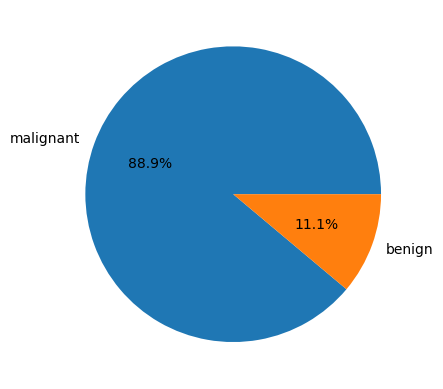

In [6]:
x = df['label'].value_counts()
plt.pie(x.values,
		labels=x.index,
		autopct='%1.1f%%')
plt.show()

# isso mostra de como o numero de dados esta desbalanceados o que provavelmente vai afetar meu resultado mas fazer o que  

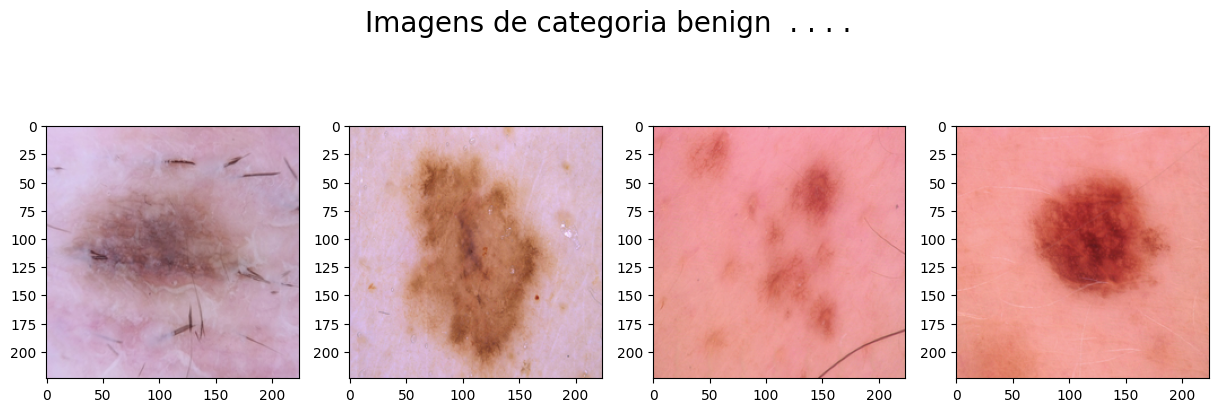

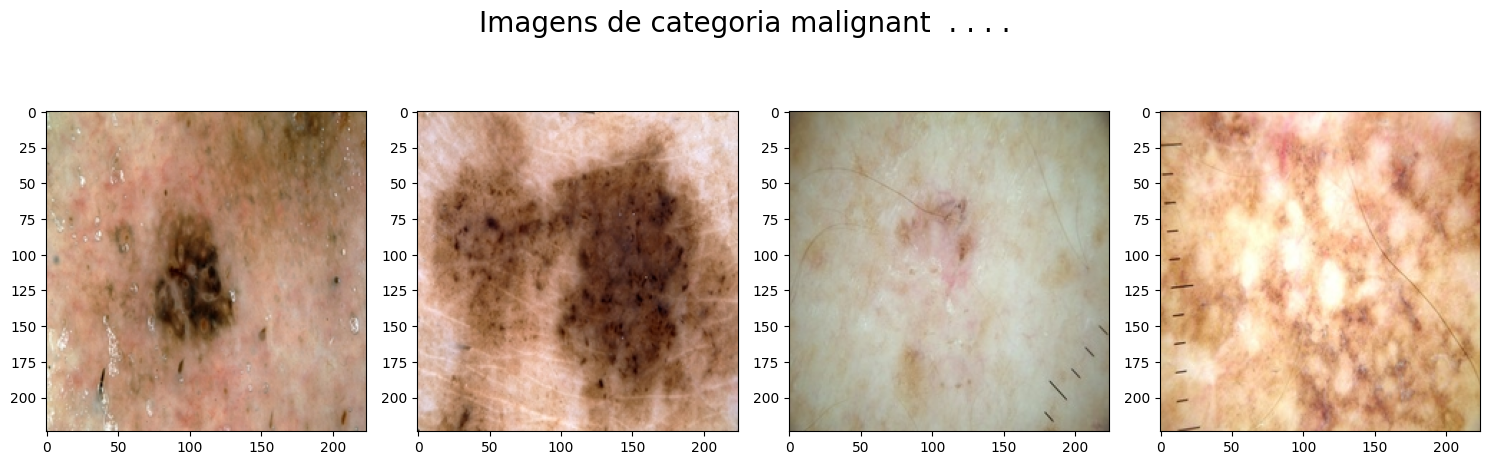

In [14]:
# basicamente mostra minhas img de cada categoria de um modo bonitinho

for categoria in df['label'].unique():
	temp = df[df['label'] == categoria]

	index_list = temp.index
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	fig.suptitle(f'Imagens de categoria {categoria}  . . . .', fontsize=20)
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]

		image_path = data[0]

		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()


# divisao de dados para o treinamento

In [15]:
features = df['caminho'] # as img sao meus dados para treinar
target = df['label_bin'] # a lbl dados para prever

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target, test_size=0.15, random_state=10) # faz essa divisao e deixa 15% para a validação o que eu pensei em aumentar mas como tem poucas img deixei 

X_train.shape, X_val.shape # mostra como ficou essa divisao


((229,), (41,))

In [16]:
display(df)

,caminho,label,label_bin
0,train_cancer/benign/12.jpg,benign,0
1,train_cancer/benign/13.jpg,benign,0
2,train_cancer/benign/14.jpg,benign,0
3,train_cancer/benign/17.jpg,benign,0
4,train_cancer/benign/19.jpg,benign,0
...,...,...,...
265,train_cancer/malignant/95.jpg,malignant,1
266,train_cancer/malignant/96.jpg,malignant,1
267,train_cancer/malignant/97.jpg,malignant,1
268,train_cancer/malignant/98.jpg,malignant,1


In [96]:
def decode_image(caminho, label=None):
 
    img = tf.io.read_file(caminho) # lê a imagem do caminho em um formato codificado do tf
    img = tf.image.decode_jpeg(img, channels=3) # Decodifica a imagem binária mas em formato JPEG
    img = tf.image.resize(img, [224, 224]) # coloca a img no ttamanho == 224, 224, o que nomalmente é 640 , 640 como o yolos usa mas e um padrao do EfficientNet 
    img = tf.cast(img, tf.float32) / 255.0 # converte os valores da imagem para float32
 
    return img, label # mostra os valores

In [86]:
print(train_ds)
print(val_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [107]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(3)
    .prefetch(AUTO)
)
 
val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(3)
    .prefetch(AUTO)
)

# Decodifica e pre-processa as imagens

In [98]:
X_train

237     train_cancer/malignant/56.jpg
159    train_cancer/malignant/235.jpg
190    train_cancer/malignant/270.jpg
169    train_cancer/malignant/248.jpg
241     train_cancer/malignant/61.jpg
                    ...              
156    train_cancer/malignant/230.jpg
123      train_cancer/malignant/2.jpg
15          train_cancer/benign/3.jpg
125    train_cancer/malignant/201.jpg
265     train_cancer/malignant/95.jpg
Name: caminho, Length: 229, dtype: object

# Desenvolvimento de modelo

In [108]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
 
pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),  # exatamente o que foi feito na funcao decode_image
    weights='imagenet',
    include_top=False
)
 
for layer in pre_trained_model.layers:
    layer.trainable = False


# usa o Transfer Learning
# muito bom para base de dados pequenas 

In [109]:
from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3)) # fala como vai ser a entrada de dados
x = layers.Flatten()(inputs)

x = layers.Dense(256, activation='relu')(x) # usa 256 neurônios
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x) # drop 30% dos neuronios de forma aleatoria para evitar overfitting
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x) # coloca uma camada a mais um neuronio ou assim funciona para saidas binarias ou seja posibilidade de duas respostas 

model = Model(inputs, outputs)

In [110]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['AUC']
)
# BinaryCrossentropy pq uso uma saida binária


'''Este código configura o modelo para ser treinado em uma tarefa de classificação binária, usando a função de perda de entropia cruzada binária (BinaryCrossentropy),
 o otimizador Adam, e a métrica AUC para avaliar o desempenho do modelo.

Função de perda: Calcula quão bem o modelo está performando comparando suas previsões (em logits) com os rótulos verdadeiros.

Otimizador: Adam é usado para ajustar os pesos do modelo durante o treinamento.

Métrica: A AUC fornece uma medida do desempenho do modelo em classificação binária, independentemente do limiar de decisão.  (fonte: gpt explica)'''

'Este código configura o modelo para ser treinado em uma tarefa de classificação binária, usando a função de perda de entropia cruzada binária (BinaryCrossentropy),\n o otimizador Adam, e a métrica AUC para avaliar o desempenho do modelo.\n\nFunção de perda: Calcula quão bem o modelo está performando comparando suas previsões (em logits) com os rótulos verdadeiros.\n\nOtimizador: Adam é usado para ajustar os pesos do modelo durante o treinamento.\n\nMétrica: A AUC fornece uma medida do desempenho do modelo em classificação binária, independentemente do limiar de decisão.  (fonte: gpt explica)'

In [111]:
print(Y_train.dtype)
print(Y_val.dtype)

int32
int32


In [117]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=1
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - AUC: 0.0000e+00 - loss: 2.7484e-04 - val_AUC: 0.0000e+00 - val_loss: 1.6352e-04
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 358ms/step - AUC: 0.0000e+00 - loss: 3.4501e-04 - val_AUC: 0.0000e+00 - val_loss: 1.5486e-04
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - AUC: 0.0000e+00 - loss: 2.5196e-04 - val_AUC: 0.0000e+00 - val_loss: 1.5319e-04
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - AUC: 0.0000e+00 - loss: 2.1090e-04 - val_AUC: 0.0000e+00 - val_loss: 1.4394e-04
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 14s 314ms/step - AUC: 0.0000e+00 - loss: 2.4593e-04 - val_AUC: 0.0000e+00 - val_loss: 1.5184e-04
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - AUC: 0.0000e+00 - loss: 2.0851e-04 - val_AUC: 0.0000e+00 - val_loss: 1.3130e-04
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 315ms/step - AUC: 0.0000e+00 - loss: 2.3678e-04 - val_AUC: 0.0000e+00 - val_loss: 1.1641e-04
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 319ms/step - 

In [118]:
hist_df = pd.DataFrame(history.history) # history resultado do treinamento e constroi um DataFrame
hist_df.head()

,AUC,loss,val_AUC,val_loss
0,0.0,0.000290,0.0,0.000164
1,0.0,0.000409,0.0,0.000155
2,0.0,0.000265,0.0,0.000153
3,0.0,0.000246,0.0,0.000144
4,0.0,0.000259,0.0,0.000152


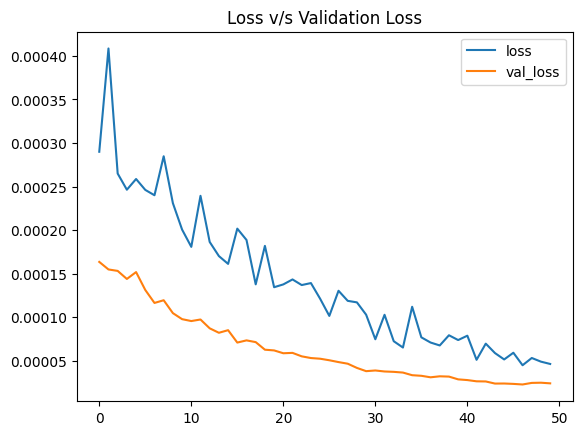

In [119]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()

# grafico do erro

In [132]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred_prob = model.predict(val_ds)
y_pred = np.round(y_pred_prob).astype(int)  

# Obter os rótulos reais do conjunto de validação
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Calcular a acurácia
accuracy = accuracy_score(y_true, y_pred)
print(f"Acurácia: {accuracy:.2f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Matriz de Confusão:
[[41]]
Acurácia: 1.00
